In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
import scipy as sp
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import plotly.express as px

plt.rcParams["figure.figsize"] = (15,8)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

In [2]:
d = pd.read_csv('/Users/sreevathsadb/Masters/Project/Data/Bike_Trips_2013_2018.csv')
d.head(5)

,id,timestamp,total_bike_stands,available_bike_stands,available_bikes,year,month,day,hour,minute,weekday,number,name,latitude,longitude,holiday,season,date_for_merge,rain,temp,wdsp,wdsp_classified,day_type,classified_time,cluster_group,bike_arr_dep,bike_arr,bike_dep,interactions,Cluster,activity_type,cluster_interaction_mean,rebalance
0,8,2013-12-04 10:30:01,0,-10,10,2013,12,4,10,30,Wednesday,8,CUSTOM HOUSE QUAY,53.347884,-6.248048,casual_day,Winter,2013-12-04 11:00:00,0.0,8.5,12.0,Moderate breeze,Weekday,6AM-10AM,6AM-10AM Weekday,-34.0,0.0,-34.0,34.0,0,rebalancing,2.0,32.0
1,1,2014-10-16 05:50:02,29,29,0,2014,10,16,5,50,Thursday,1,CLARENDON ROW,53.340883,-6.262542,casual_day,Autumn,2014-10-16 06:00:00,0.0,8.5,5.0,Light breeze,Weekday,Overnight,Overnight Weekday,2.0,2.0,0.0,2.0,0,rental,2.0,0.0
2,1,2014-10-16 06:00:02,29,27,2,2014,10,16,6,0,Thursday,1,CLARENDON ROW,53.340883,-6.262542,casual_day,Autumn,2014-10-16 06:00:00,0.0,8.5,5.0,Light breeze,Weekday,6AM-10AM,6AM-10AM Weekday,1.0,1.0,0.0,1.0,0,rental,2.0,0.0
3,1,2014-10-16 06:10:01,29,26,3,2014,10,16,6,10,Thursday,1,CLARENDON ROW,53.340883,-6.262542,casual_day,Autumn,2014-10-16 06:00:00,0.0,8.5,5.0,Light breeze,Weekday,6AM-10AM,6AM-10AM Weekday,1.0,1.0,0.0,1.0,0,rental,2.0,0.0
4,1,2014-10-16 06:20:02,29,25,4,2014,10,16,6,20,Thursday,1,CLARENDON ROW,53.340883,-6.262542,casual_day,Autumn,2014-10-16 06:00:00,0.0,8.5,5.0,Light breeze,Weekday,6AM-10AM,6AM-10AM Weekday,2.0,2.0,0.0,2.0,0,rental,3.0,0.0


# iDAM Model Implementation

## Data Preparation for iDAM model

In [3]:
trips_per_day = d.groupby(['year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trips_per_day['trips'] = trips_per_day['interactions']/2
trips_per_day['transformed_trips'] = (trips_per_day['interactions'] + abs(trips_per_day['bike_arr_dep']) - trips_per_day['rebalance'])/2
trips_per_day['transformed_trips']  = trips_per_day['transformed_trips'].apply(np.ceil)
df_idam = trips_per_day[['transformed_trips','trips']]
df_idam['trips']  = df_idam['trips'].apply(np.ceil)
df_idam['trips_2'] = df_idam['trips'] * df_idam['trips']
df_idam.sample(5)

,transformed_trips,trips,trips_2
1122,5198.0,5846.0,34175716.0
34,2120.0,2201.0,4844401.0
3,5290.0,5714.0,32649796.0
85,4558.0,4884.0,23853456.0
1407,5531.0,6356.0,40398736.0


## Training and Testing iDAM Model

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(df_idam,df_idam, test_size = 0.3,random_state=0)
idam_model = smf.ols(formula='transformed_trips ~ 0 + trips + trips_2', data=xtrain).fit()
y_pred = idam_model.predict(xtest)
print(idam_model.summary())

                                 OLS Regression Results                                
Dep. Variable:      transformed_trips   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          8.705e+05
Date:                Sun, 07 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:48:44   Log-Likelihood:                         -6563.1
No. Observations:                1072   AIC:                                  1.313e+04
Df Residuals:                    1070   BIC:                                  1.314e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [5]:
residuals = xtest['transformed_trips']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_trips'], y_pred))/(xtest['transformed_trips'].mean())))


Mean of Residuals -1.767655684518389
NRMSE 0.025228254312893546


## Verifying Linear Assumption(iDAM)

Linear regression is an analysis that assesses whether one or more predictor variables explain the dependent (criterion) variable.  The regression has five key assumptions:

1) Linear relationship. 

2) Normality. 

3) Homoscedasticity.

4) No auto-correlation.

### Linearity

<AxesSubplot:xlabel='trips', ylabel='transformed_trips'>

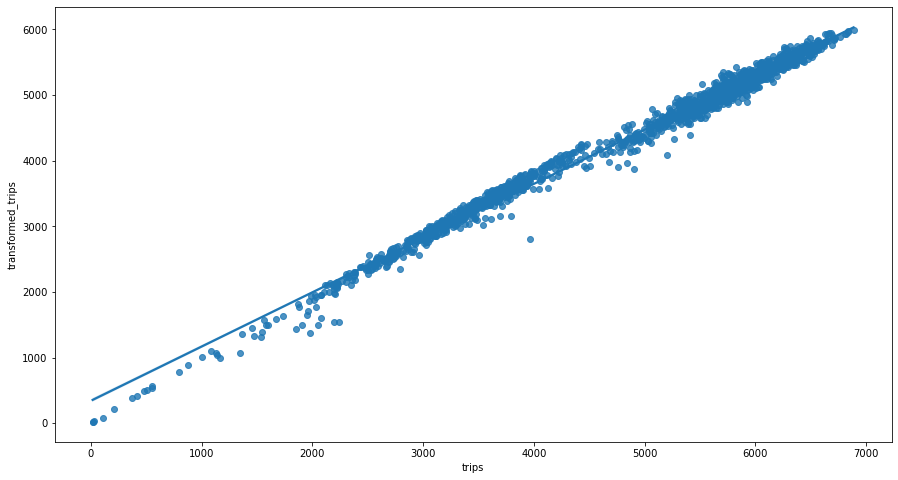

In [6]:
plt.rcParams["figure.figsize"] = (15,8)
sns.regplot(x=df_idam["trips"], y=df_idam["transformed_trips"])

### Heteroscedasticity

#### Residual Vs Fitted Plot

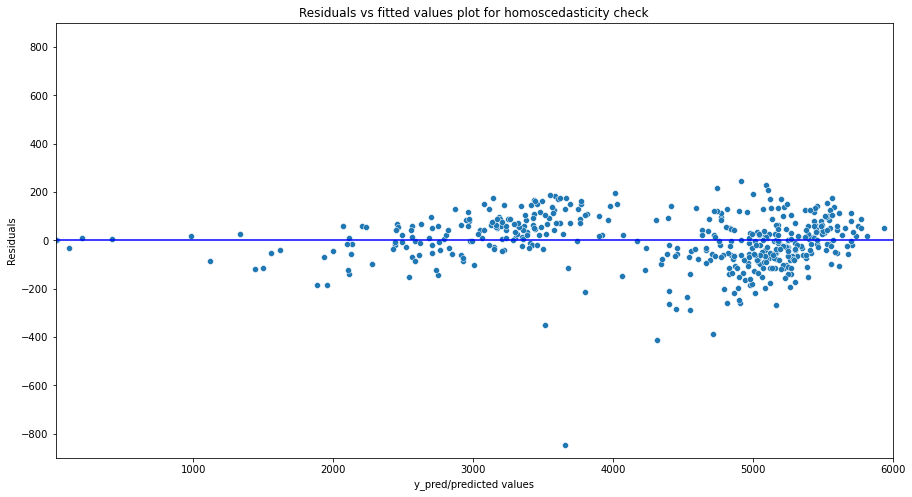

In [7]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-900,900)
plt.xlim(17,6000)
p = sns.lineplot([17,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [8]:
#### Goldfeld Quandt Test

Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic.

Alternative Hypothesis: Error terms are heteroscedastic.

In [9]:
X_train =  xtest.drop(["transformed_trips"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 0.8922233234207652), ('p-value', 0.8050498149250729)]

Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic. Good

### Normality

#### Histogram

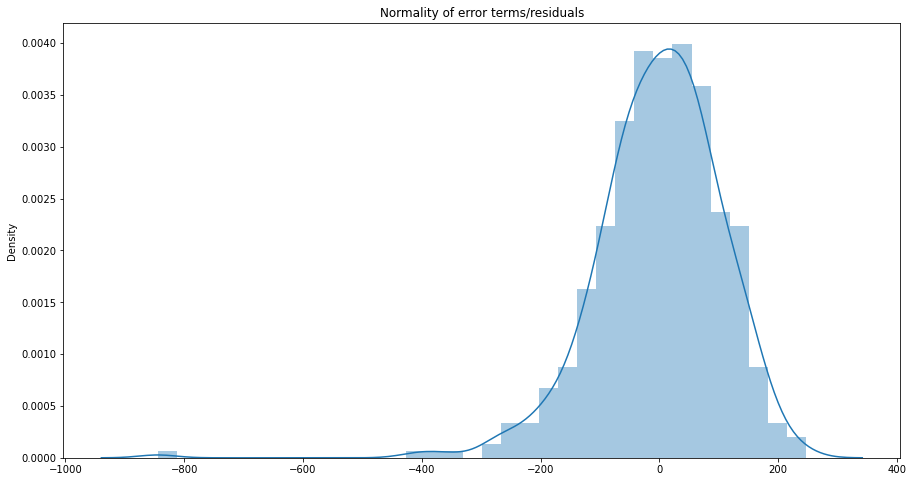

In [10]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

#### QQplot

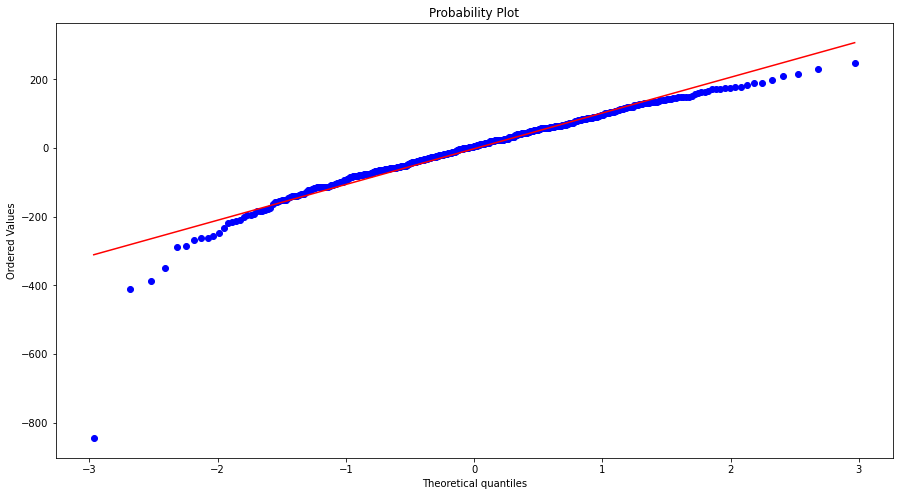

In [11]:
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residuals, plot=ax, fit=True)

### Autocorrelation

#### Autocorrelation plot for residuals

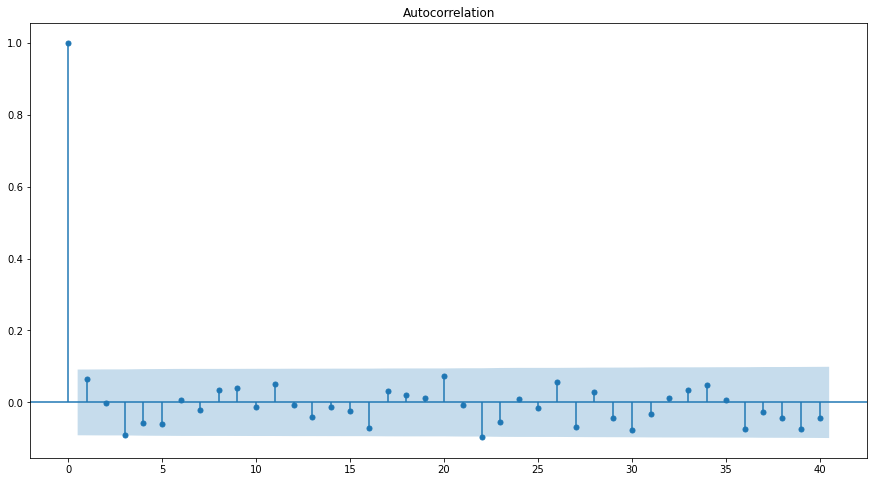

In [12]:
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

There results doesn't show any auto correlation, as we couldnt see any spikes outsided the blue confidence interval region.

#### Ljung Box Test

Checking for autocorrelation To ensure the absence of autocorrelation we use \             test.

Null Hypothesis: Autocorrelation is absent.

Alternative Hypothesis: Autocorrelation is present.

In [13]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.10683730640501404

Since p value is greater than 0.05 we fail to reject null hypothesis. Hence Auto Correlation is not present which is Good

Reference : https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression/notebook

# cDAM Model Implementation

## Data Preparation for cDAM model

In [14]:
#### Data Preparation for CDAM model
trips_per_day = d.groupby(['year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trips_per_day['trips'] = trips_per_day['interactions']/2
trips_per_day['transformed_trips'] = (trips_per_day['interactions'] + abs(trips_per_day['bike_arr_dep']) - trips_per_day['rebalance'])/2
trips_per_day['transformed_trips']  = trips_per_day['transformed_trips'].apply(np.ceil)
active_stations = d.groupby(['year','month','day'])['interactions'].count().reset_index(name ='activity_count')

df_cdam = pd.merge(trips_per_day, active_stations, on = ['year','month','day'], how = 'inner')
df_cdam['trips']  = df_cdam['trips'].apply(np.ceil)
df_cdam['trips_sq'] =  df_cdam['trips'] * df_cdam['trips']
df_cdam['trips_sq_activity_normalised'] = df_cdam['trips_sq'] / df_cdam['activity_count']
df_cdam = df_cdam[['transformed_trips','trips','trips_sq_activity_normalised']]
df_cdam.sample(5)

,transformed_trips,trips,trips_sq_activity_normalised
967,4727.0,5318.0,5379.707818
773,5183.0,5924.0,6372.575994
143,3088.0,3343.0,3137.464627
1024,4512.0,5121.0,5465.744268
1283,4863.0,5417.0,5316.885124


## Training and Testing cDAM Model

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(df_cdam,df_cdam, test_size = 0.3,random_state=0)
cdam_model = smf.ols(formula='transformed_trips ~ 0 + trips + trips_sq_activity_normalised', data=xtrain).fit()
y_pred = cdam_model.predict(xtest)
print(cdam_model.summary())

                                 OLS Regression Results                                
Dep. Variable:      transformed_trips   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.791e+06
Date:                Sun, 07 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:48:46   Log-Likelihood:                         -6176.7
No. Observations:                1072   AIC:                                  1.236e+04
Df Residuals:                    1070   BIC:                                  1.237e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [16]:
residuals = xtest['transformed_trips']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_trips'], y_pred))/(xtest['transformed_trips'].mean())))

Mean of Residuals -2.9329152514901278
NRMSE 0.01753417378973817


### Linearity

<AxesSubplot:xlabel='trips', ylabel='transformed_trips'>

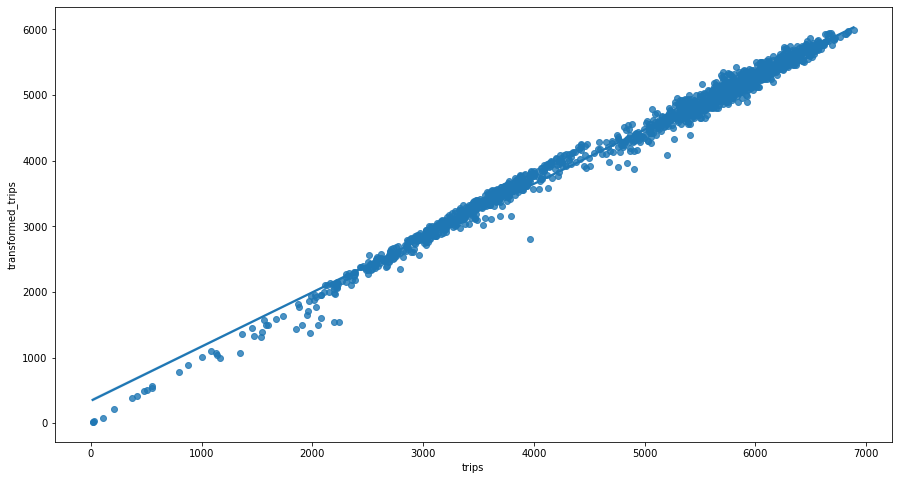

In [17]:
sns.regplot(x=df_cdam["trips"], y=df_cdam["transformed_trips"])

### Heteroscedasticity

#### Residual Vs Fitted Plot

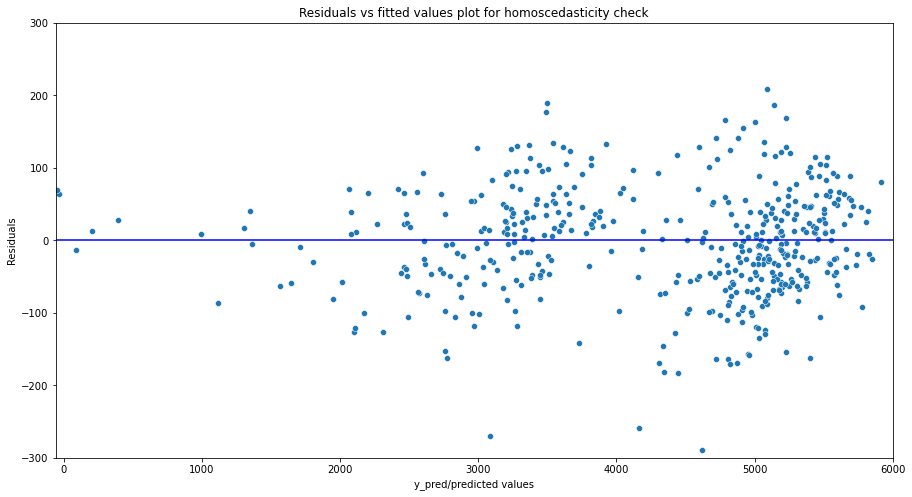

In [18]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-300,300)
plt.xlim(-60,6000)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

#### Goldfeld Quandt Test

In [19]:
X_train =  xtest.drop(["transformed_trips"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0345248022192928), ('p-value', 0.39898662622064196)]

### Normality

### Histogram

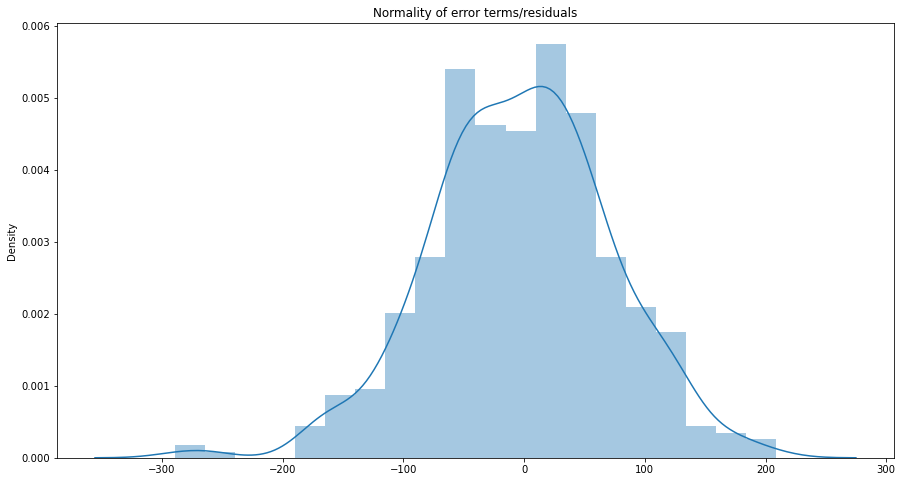

In [20]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

#### QQplot

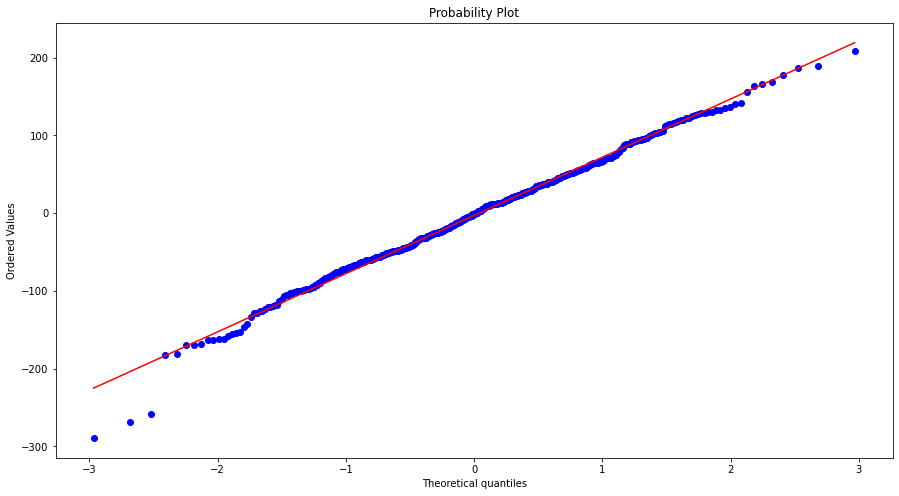

In [21]:
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residuals, plot=ax, fit=True)

### Autocorrelation

#### Autocorrelation plot for residuals

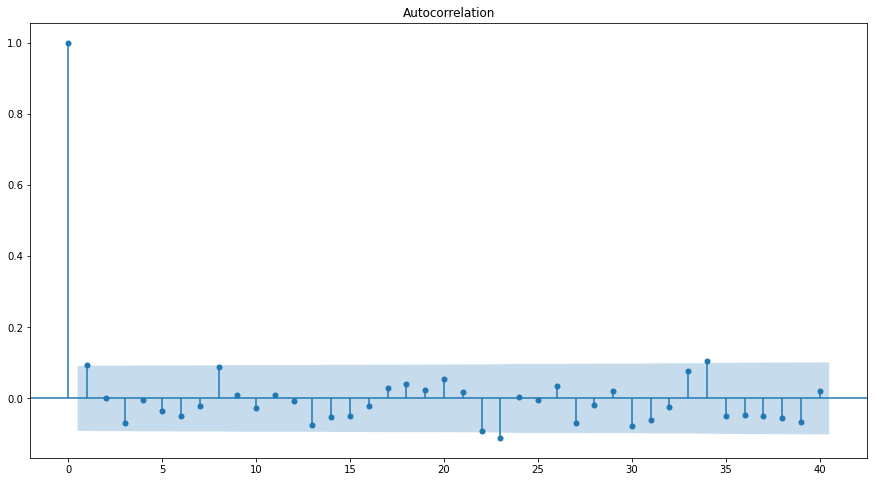

In [22]:
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

#### Ljung Box Test

In [23]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.04168691149849478

# IAM Model Implementation

## Data Preparation for IAM model

In [24]:
trip_df = d.groupby(['year','month','day','hour','minute'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trip_df.head(5)
trip_df['transformed_interactions'] = (trip_df['interactions'] + abs(trip_df['bike_arr_dep']) - trip_df['rebalance'])
active_stations_df = d.groupby(['year','month','day','hour','minute'])['interactions'].count().reset_index(name ='active_stations')

df_iam = pd.merge(trip_df, active_stations_df, on = ['year','month','day','hour','minute'], how = 'inner')
df_iam = df_iam[['transformed_interactions','interactions','active_stations']]
df_iam['active_stations_sq'] = df_iam['active_stations'] * df_iam['active_stations']
df_iam.sample(5)

,transformed_interactions,interactions,active_stations,active_stations_sq
112523,111.0,108.0,56,3136
28217,86.0,76.0,43,1849
16790,44.0,44.0,27,729
14207,56.0,46.0,30,900
165582,93.0,103.0,55,3025


## Training and Testing IAM Model

In [25]:
xtrain, xtest, ytrain, ytest = train_test_split(df_iam,df_iam, test_size = 0.3,random_state=0)
iam_model = smf.ols(formula='transformed_interactions ~ 0 + interactions + active_stations + active_stations_sq', data=xtrain).fit()
y_pred = iam_model.predict(xtest)
print(iam_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     transformed_interactions   R-squared (uncentered):                   0.978
Model:                                  OLS   Adj. R-squared (uncentered):              0.978
Method:                       Least Squares   F-statistic:                          1.928e+06
Date:                      Sun, 07 Aug 2022   Prob (F-statistic):                        0.00
Time:                              12:48:48   Log-Likelihood:                     -5.3879e+05
No. Observations:                    130339   AIC:                                  1.078e+06
Df Residuals:                        130336   BIC:                                  1.078e+06
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
                         coef    std err          t      P>|

In [26]:
residuals = xtest['transformed_interactions']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_interactions'], y_pred))/(xtest['transformed_interactions'].mean())))

Mean of Residuals 0.08922462267120752
NRMSE 0.17267743893797277


### Linearity

<AxesSubplot:xlabel='transformed_interactions', ylabel='interactions'>

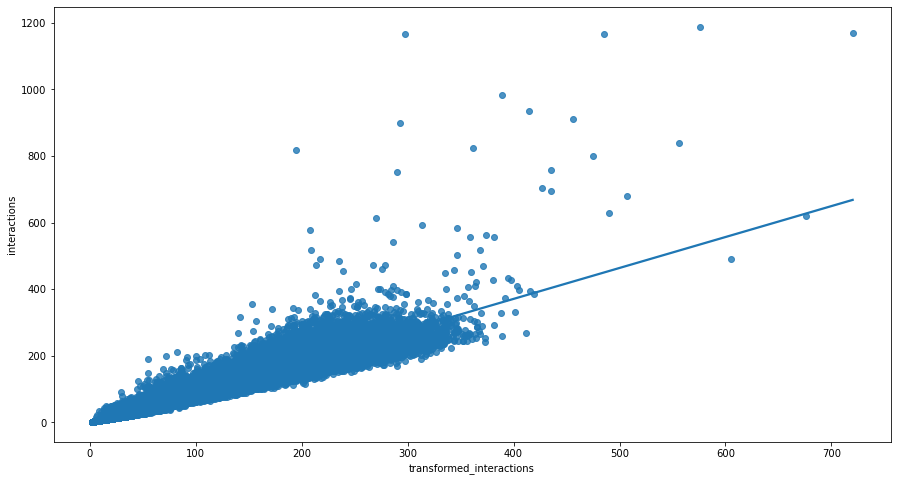

In [27]:
sns.regplot(x=df_iam["transformed_interactions"], y=df_iam["interactions"])

### Heteroscedasticity

#### Residual Vs Fitted Plot

p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-500,500)
plt.xlim(-6,500)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

#### Goldfeld Quandt Test

In [28]:
X_train =  xtest.drop(["transformed_interactions"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.067851104035813), ('p-value', 2.0693824079471374e-08)]

### Normality

#### Histogram

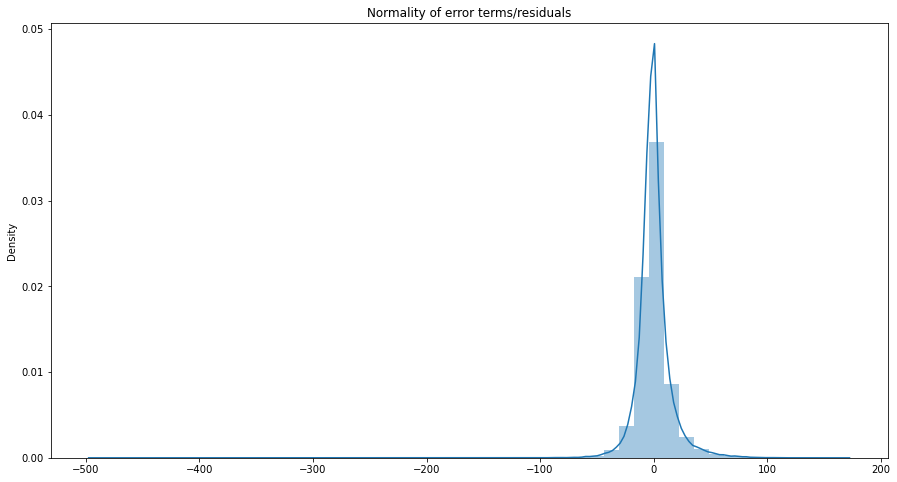

In [29]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

#### QQplot

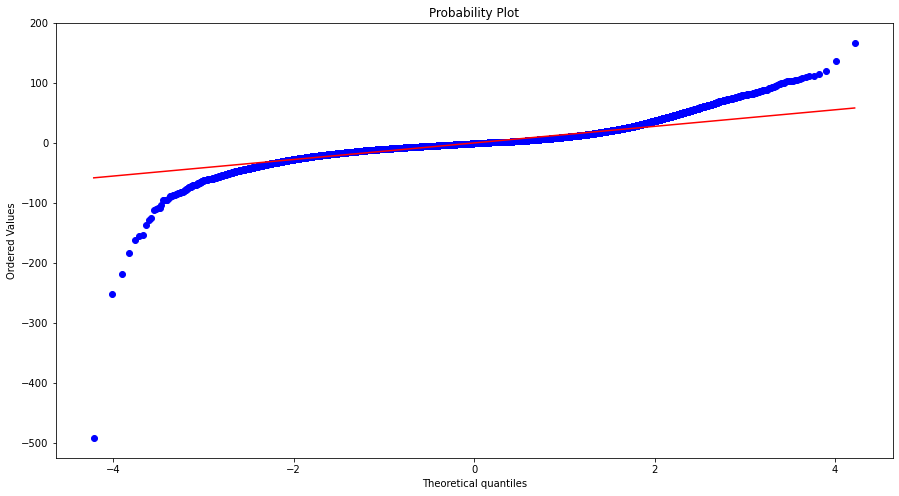

In [30]:
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residuals, plot=ax, fit=True)

### Autocorrelation

#### Autocorrelation plot for residuals

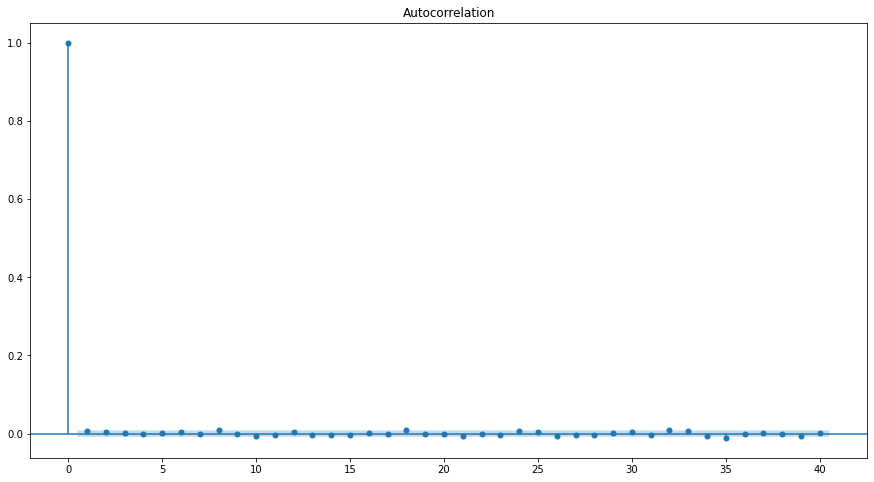

In [31]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

#### Ljung Box Test

In [32]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.07467984717414049

# SAM Model Implementation

## Data Preparation for SAM model

In [33]:
trip_df = d.groupby(['id','Cluster','year','month','day'])['interactions', 'rebalance','bike_arr_dep'].sum().reset_index()
trip_df.head(5)
trip_df['transformed_interactions'] = (trip_df['interactions'] + abs(trip_df['bike_arr_dep']) - trip_df['rebalance'])
active_stations_df = d.groupby(['id','Cluster','year','month','day'])['interactions'].count().reset_index(name ='activity_count')

df_sam = pd.merge(trip_df, active_stations_df, on = ['id','Cluster','year','month','day'], how = 'inner')
df_sam = df_sam[['transformed_interactions','interactions','activity_count']]
df_sam['activity_count_sq'] = df_sam['activity_count'] * df_sam['activity_count']
df_sam.sample(5)

,transformed_interactions,interactions,activity_count,activity_count_sq
135261,90.0,106.0,51,2601
70215,118.0,94.0,37,1369
44297,158.0,157.0,63,3969
84215,83.0,110.0,42,1764
45659,164.0,158.0,79,6241


## Training and Testing SAM Model

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(df_sam,df_sam, test_size = 0.3,random_state=0)
sam_model = smf.ols(formula='transformed_interactions ~ 0 + interactions + activity_count + activity_count_sq', data=xtrain).fit()
y_pred = sam_model.predict(xtest)
print(sam_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     transformed_interactions   R-squared (uncentered):                   0.992
Model:                                  OLS   Adj. R-squared (uncentered):              0.992
Method:                       Least Squares   F-statistic:                          3.885e+06
Date:                      Sun, 07 Aug 2022   Prob (F-statistic):                        0.00
Time:                              12:49:06   Log-Likelihood:                     -3.6973e+05
No. Observations:                     99241   AIC:                                  7.395e+05
Df Residuals:                         99238   BIC:                                  7.395e+05
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
                        coef    std err          t      P>|t

In [35]:
residuals = xtest['transformed_interactions']-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print("NRMSE {}".format(np.sqrt(mean_squared_error(xtest['transformed_interactions'], y_pred))/(xtest['transformed_interactions'].mean())))


Mean of Residuals 0.30017497800853565
NRMSE 0.10136263419554808


### Linearity

<AxesSubplot:xlabel='transformed_interactions', ylabel='interactions'>

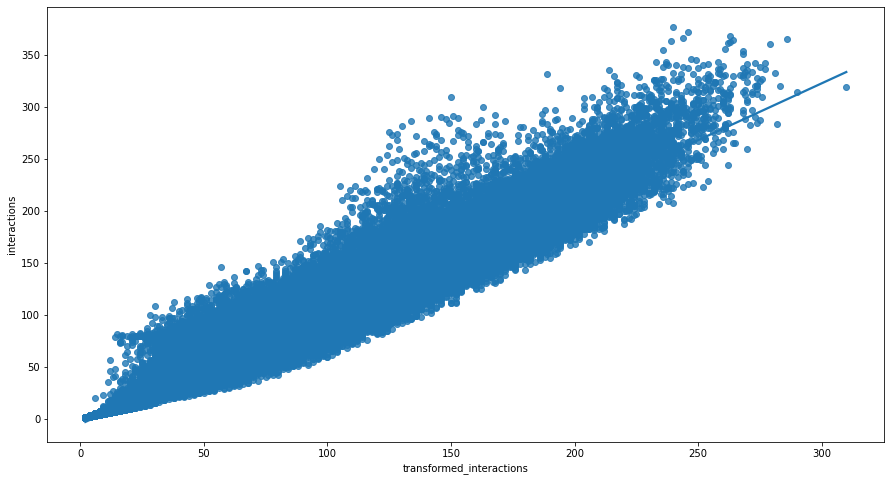

In [36]:
sns.regplot(x=df_sam["transformed_interactions"], y=df_sam["interactions"])

### Heteroscedasticity

#### Residual Vs Fitted Plot

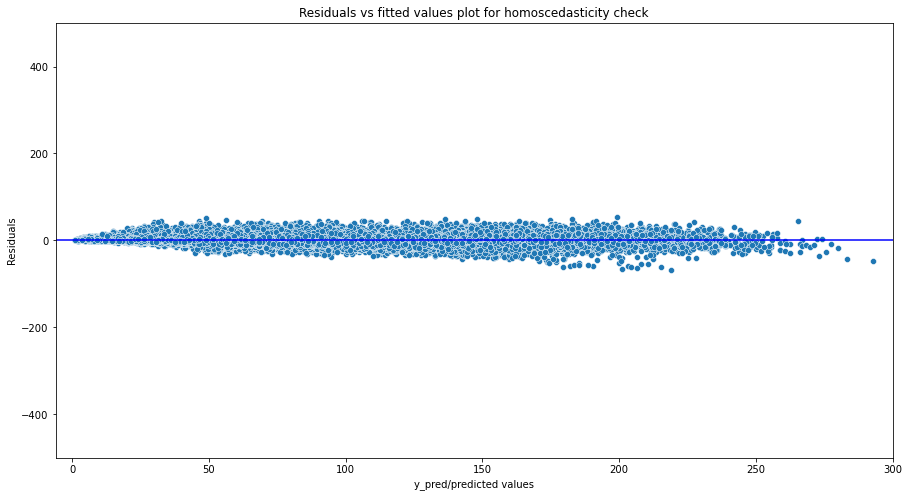

In [37]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-500,500)
plt.xlim(-6,300)
p = sns.lineplot([-60,6000],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

#### Goldfeld Quandt Test

In [38]:
X_train =  xtest.drop(["transformed_interactions"],axis=1)
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0091666571188267), ('p-value', 0.252935719783884)]

### Normality

#### Histogram

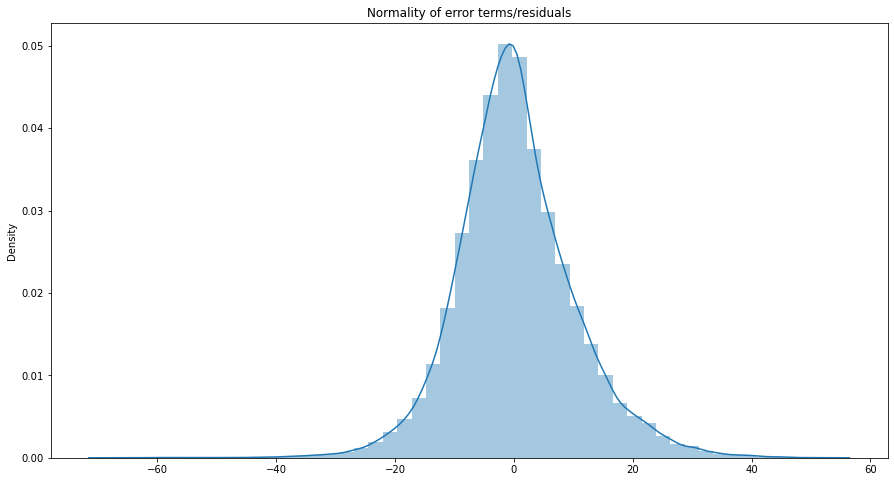

In [39]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

#### QQplot

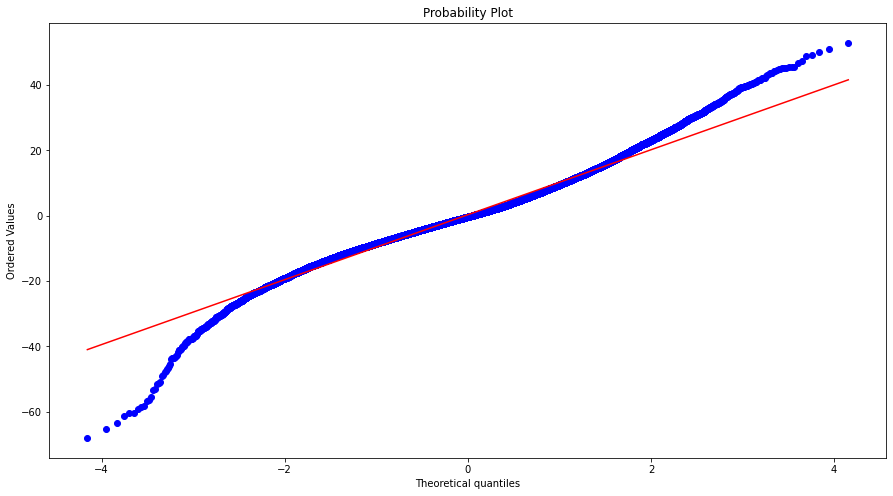

In [40]:
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residuals, plot=ax, fit=True)

### Autocorrelation

#### Autocorrelation plot for residuals

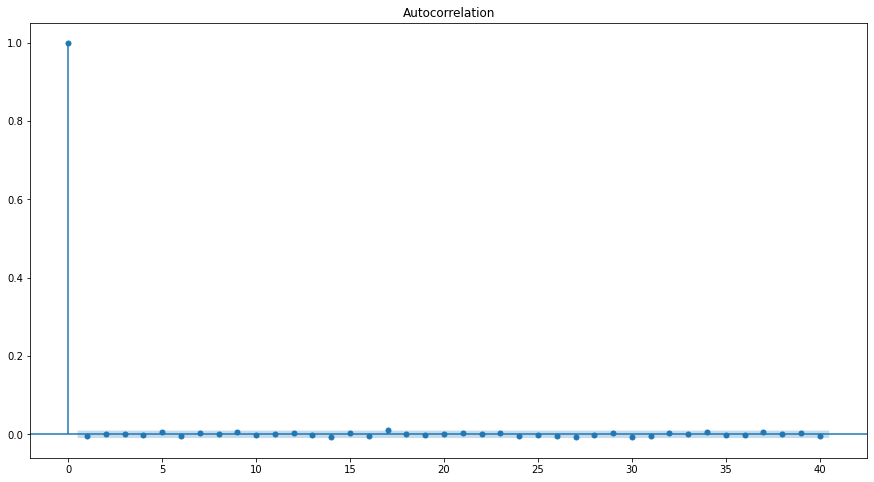

In [41]:
plt.rcParams["figure.figsize"] = (15,8)
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

#### Ljung Box Test

In [42]:
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.5024147505465011